<a href="https://colab.research.google.com/github/sofiasdz/deep_learning/blob/sofi-branch/DeepLeaning_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Leaning TP


Kaggle Dataset


In [ ]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 87 kB 2.9 MB/s 
     |████████████████████████████████| 58 kB 3.6 MB/s 
     |████████████████████████████████| 376 kB 38.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6ae6aa31993635947c4cf277c6e1d1baef300288e9e3ac1ffd3bad3ef2c7fdec
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e75b929f840c685eb9d59fb24f6501e68390728590280e765534ec982f40965f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter

from PIL import Image,ImageFile
import albumentations as A
import matplotlib.pyplot as plt

from sklearn import model_selection
import segmentation_models_pytorch as smp

import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

ImageFile.LOAD_TRUNCATED_IMAGES = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

In [ ]:
class SIIMDataset(Dataset):
    
    def __init__(self, df, data_dir, transform=None, preprocessing_fun=None, channel_first=True):
        self.data_dir = data_dir
        self.transform = transform                       # for augmentations
        self.preprocessing_fun = preprocessing_fun       # preprocessing_fun to normalize images
        self.channel_first = channel_first               # set channels as first dimension
        self.image_ids = df.ImageId.values
        self.group_by = df.groupby('ImageId')

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        df = self.group_by.get_group(img_id)
        annotations = df[' EncodedPixels'].tolist()
        
        img_path = os.path.join(self.data_dir, img_id + ".png")
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        mask = np.zeros(shape=(1024,1024))
        if annotations[0] != ' -1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32')
        mask = np.expand_dims(mask, axis=-1)
        
        # apply augmentation
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        if self.preprocessing_fun:
            img = self.preprocessing_fun(img)
        
        # convert shape from (width, height, channel) ----> (channel, width, height) 
        if self.channel_first:
            img = np.transpose(img, (2, 0, 1)).astype(np.float32)
            mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        return {
            'image': torch.Tensor(img),
            'mask': torch.Tensor(mask)
        }

In [ ]:
def train(data_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0
    for data in tqdm(data_loader):
        inputs = data['image']
        labels = data['mask']

        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    return train_loss/len(data_loader)

In [ ]:
def evaluate(data_loader, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs = data['image']
            labels = data['mask']

            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

    return eval_loss/len(data_loader)

In [ ]:
# Intialize some useful variables

#DATA_DIR = '../input/siim-png-images/train_png'
#data_csv = '../input/siim-acr-pneumothorax-segmentation-data/train-rle.csv'
DATA_DIR = '/content/train_png'
data_csv = '/content/pneumothorax/train-rle.csv'
batch_size = 32

Encoder = 'resnet34'
Weights = 'imagenet'

In [ ]:
# Define augmentation and preprocessing-function(according to Encoder)

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.OneOf([A.RandomGamma(gamma_limit=(90,110)),
             A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)], p=0.5),
    A.Resize(width=224, height=224)
])

prep_fun = smp.encoders.get_preprocessing_fn(
    Encoder,
    Weights
)

In [ ]:
# Split data into training and validation

df = pd.read_csv(data_csv)
df_train, df_val = model_selection.train_test_split(df, test_size=0.15)

In [ ]:
# Initialize Dataset
train_dataset = SIIMDataset(df_train,
                            DATA_DIR,
                            transform = transform,
                            preprocessing_fun = prep_fun)

val_dataset = SIIMDataset(df_val,
                          DATA_DIR,
                          transform = transform,
                          preprocessing_fun = prep_fun)

# Create DataLoader
train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 8)

val_loader = DataLoader(val_dataset,
                        batch_size = batch_size,
                        num_workers = 4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Explore DataLoader

print('Training data Info:')
dataiter = iter(train_loader)
data = dataiter.next()
images,labels = data['image'],data['mask']
print("shape of images : {}".format(images.shape))
print("shape of labels : {}".format(labels.shape))

print('\nValidation data Info:')
dataiter = iter(val_loader)
data = dataiter.next()
images,labels = data['image'],data['mask']
print("shape of images : {}".format(images.shape))
print("shape of labels : {}".format(labels.shape))

Training data Info:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


shape of images : torch.Size([32, 3, 224, 224])
shape of labels : torch.Size([32, 1, 224, 224])

Validation data Info:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


shape of images : torch.Size([32, 3, 224, 224])
shape of labels : torch.Size([32, 1, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


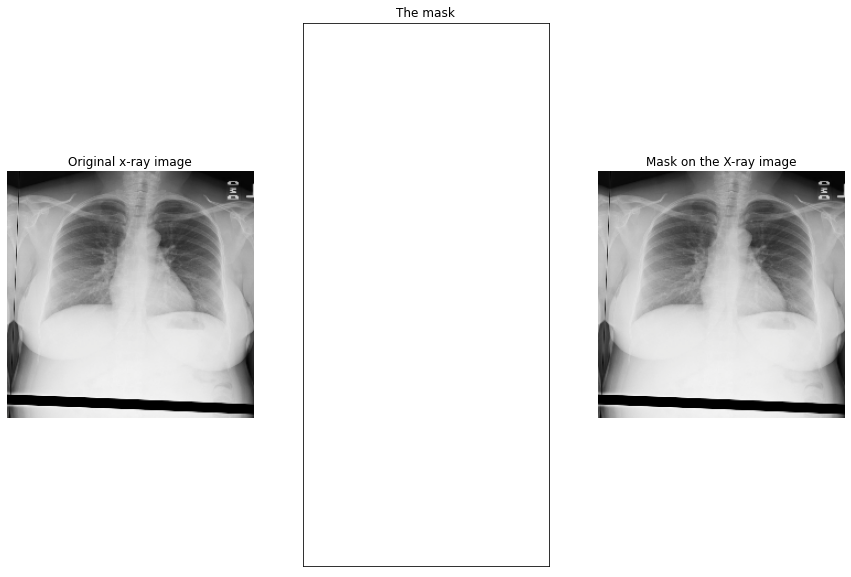

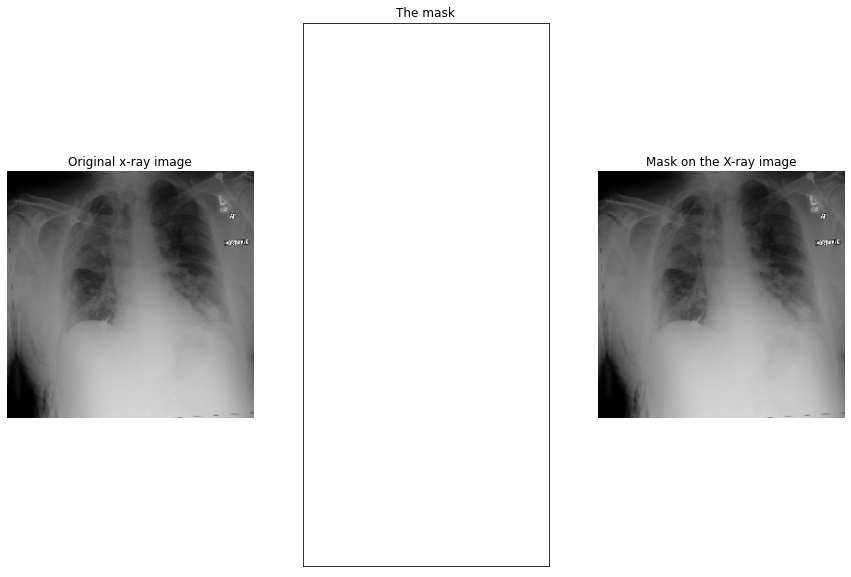

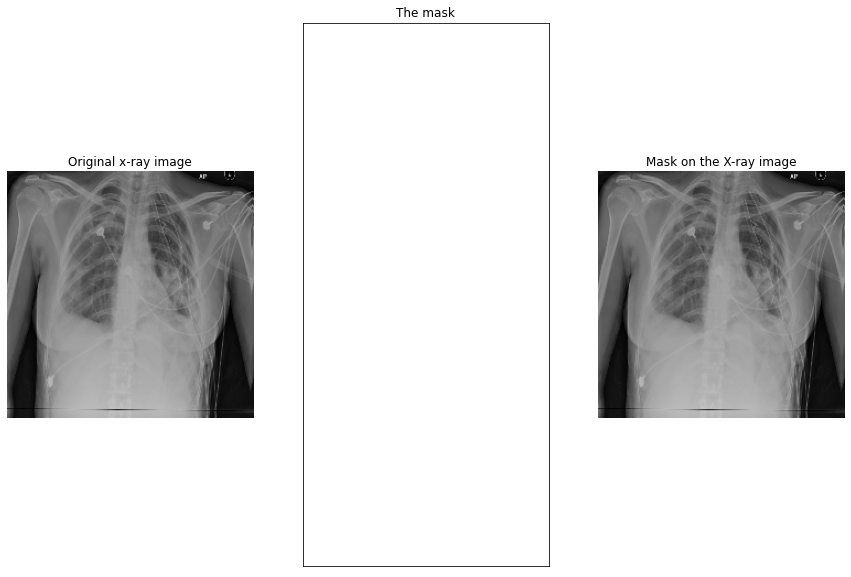

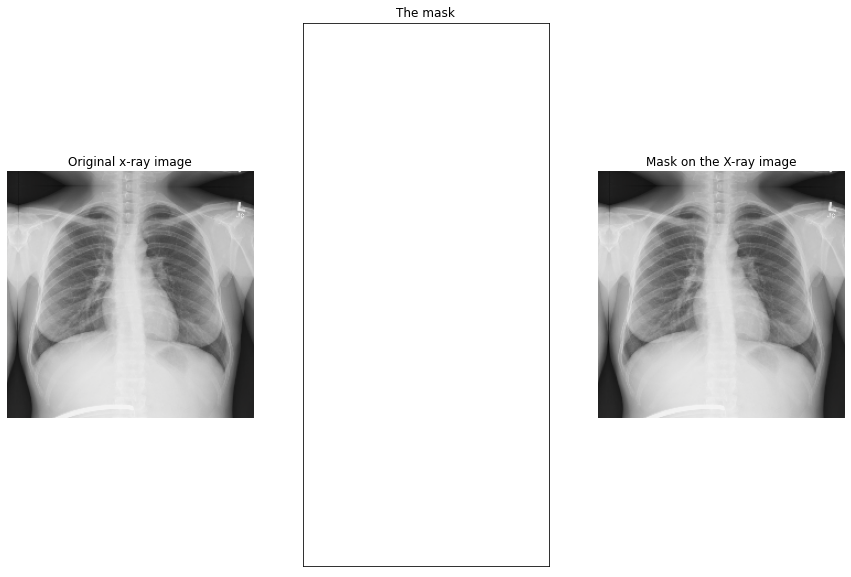

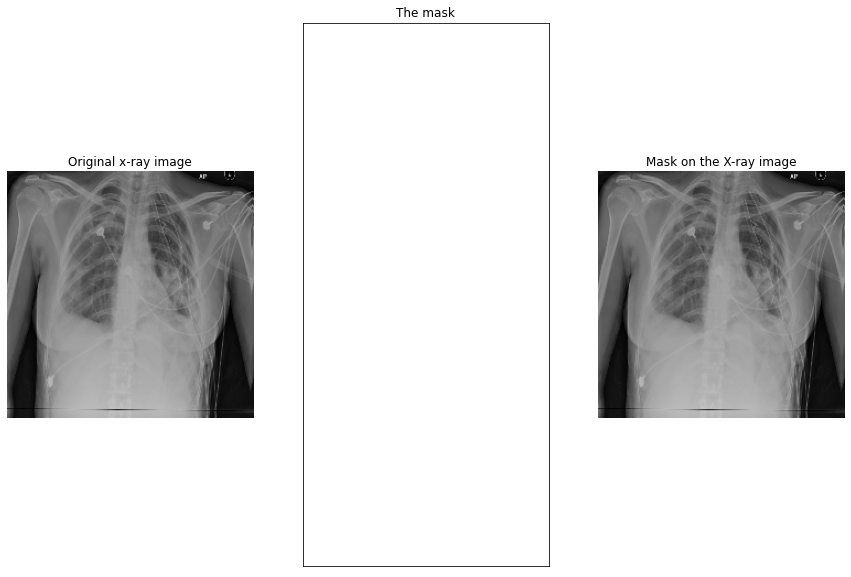

In [ ]:
def denoramlize(img):
    img = img.permute(1,2,0)            # change shape ---> (width, height, channel)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    img = img*std + mean
    img = np.clip(img,0,1)              # convert the pixel values range(min=0, max=1)
    return img

def imshow(img, mask):
    fig = plt.figure(figsize=(15, 10))
    a = fig.add_subplot(1, 3, 1)
    plt.imshow(denoramlize(img), cmap='bone')
    a.set_title("Original x-ray image")
    plt.grid(False)
    plt.axis("off")

    a = fig.add_subplot(1, 3, 2)
    #imgplot = plt.imshow(torch.squeeze(mask, dim=1).permute(1,2,0), cmap='binary')
    a.set_title("The mask")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    a = fig.add_subplot(1, 3, 3)
    plt.imshow(denoramlize(img), cmap='bone')
    #plt.imshow(torch.squeeze(mask, dim=1).permute(1,2,0), cmap='binary', alpha=0.3)
    a.set_title("Mask on the X-ray image")

    plt.axis("off")
    plt.grid(False)


def show_batch_image(dataloader, num_images):
    data = next(iter(dataloader))
    image,mask = data['image'],data['mask']
    img_idx = torch.randint(0, dataloader.batch_size, (num_images,))
    for i in img_idx:
        imshow(image[i], mask[i])

show_batch_image(train_loader, 5)

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()
        
class MixedLoss(nn.Module):
    def __init__(self, alpha=None, gamma=None):
        super().__init__()
#         self.alpha = alpha
#         self.focal = FocalLoss(gamma)

    def forward(self, input, target):
#         loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        loss = -torch.log(dice_loss(input, target))

        return loss.mean()

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.nn import functional as F


def get_backbone(name, pretrained=True):

    """ Loading backbone, defining names for skip-connections and encoder output. """

    # TODO: More backbones

    # loading backbone model
    if name == 'resnet18':
        backbone = models.resnet18(pretrained=pretrained)
    elif name == 'resnet34':
        backbone = models.resnet34(pretrained=pretrained)
    elif name == 'resnet50':
        backbone = models.resnet50(pretrained=pretrained)
    elif name == 'resnet101':
        backbone = models.resnet101(pretrained=pretrained)
    elif name == 'resnet152':
        backbone = models.resnet152(pretrained=pretrained)
    elif name == 'vgg16':
        backbone = models.vgg16_bn(pretrained=pretrained).features
    elif name == 'vgg19':
        backbone = models.vgg19_bn(pretrained=pretrained).features
    # elif name == 'inception_v3':
    #     backbone = models.inception_v3(pretrained=pretrained, aux_logits=False)
    elif name == 'densenet121':
        backbone = models.densenet121(pretrained=True).features
    elif name == 'densenet161':
        backbone = models.densenet161(pretrained=True).features
    elif name == 'densenet169':
        backbone = models.densenet169(pretrained=True).features
    elif name == 'densenet201':
        backbone = models.densenet201(pretrained=True).features
    elif name == 'unet_encoder':
        from unet_backbone import UnetEncoder
        backbone = UnetEncoder(3)
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))

    # specifying skip feature and output names
    if name.startswith('resnet'):
        feature_names = [None, 'relu', 'layer1', 'layer2', 'layer3']
        backbone_output = 'layer4'
    elif name == 'vgg16':
        # TODO: consider using a 'bridge' for VGG models, there is just a MaxPool between last skip and backbone output
        feature_names = ['5', '12', '22', '32', '42']
        backbone_output = '43'
    elif name == 'vgg19':
        feature_names = ['5', '12', '25', '38', '51']
        backbone_output = '52'
    # elif name == 'inception_v3':
    #     feature_names = [None, 'Mixed_5d', 'Mixed_6e']
    #     backbone_output = 'Mixed_7c'
    elif name.startswith('densenet'):
        feature_names = [None, 'relu0', 'denseblock1', 'denseblock2', 'denseblock3']
        backbone_output = 'denseblock4'
    elif name == 'unet_encoder':
        feature_names = ['module1', 'module2', 'module3', 'module4']
        backbone_output = 'module5'
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))

    return backbone, feature_names, backbone_output


class UpsampleBlock(nn.Module):

    # TODO: separate parametric and non-parametric classes?
    # TODO: skip connection concatenated OR added

    def __init__(self, ch_in, ch_out=None, skip_in=0, use_bn=True, parametric=False):
        super(UpsampleBlock, self).__init__()

        self.parametric = parametric
        ch_out = ch_in/2 if ch_out is None else ch_out

        # first convolution: either transposed conv, or conv following the skip connection
        if parametric:
            # versions: kernel=4 padding=1, kernel=2 padding=0
            self.up = nn.ConvTranspose2d(in_channels=ch_in, out_channels=ch_out, kernel_size=(4, 4),
                                         stride=2, padding=1, output_padding=0, bias=(not use_bn))
            self.bn1 = nn.BatchNorm2d(ch_out) if use_bn else None
        else:
            self.up = None
            ch_in = ch_in + skip_in
            self.conv1 = nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=(3, 3),
                                   stride=1, padding=1, bias=(not use_bn))
            self.bn1 = nn.BatchNorm2d(ch_out) if use_bn else None

        self.relu = nn.ReLU(inplace=True)

        # second convolution
        conv2_in = ch_out if not parametric else ch_out + skip_in
        self.conv2 = nn.Conv2d(in_channels=conv2_in, out_channels=ch_out, kernel_size=(3, 3),
                               stride=1, padding=1, bias=(not use_bn))
        self.bn2 = nn.BatchNorm2d(ch_out) if use_bn else None

    def forward(self, x, skip_connection=None):

        x = self.up(x) if self.parametric else F.interpolate(x, size=None, scale_factor=2, mode='bilinear',
                                                             align_corners=None)
        if self.parametric:
            x = self.bn1(x) if self.bn1 is not None else x
            x = self.relu(x)

        if skip_connection is not None:
            x = torch.cat([x, skip_connection], dim=1)

        if not self.parametric:
            x = self.conv1(x)
            x = self.bn1(x) if self.bn1 is not None else x
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x) if self.bn2 is not None else x
        x = self.relu(x)

        return x


class Unet(nn.Module):

    """ U-Net (https://arxiv.org/pdf/1505.04597.pdf) implementation with pre-trained torchvision backbones."""

    def __init__(self,
                 backbone_name='resnet50',
                 pretrained=True,
                 encoder_freeze=False,
                 classes=21,
                 decoder_filters=(256, 128, 64, 32, 16),
                 parametric_upsampling=True,
                 shortcut_features='default',
                 decoder_use_batchnorm=True):
        super(Unet, self).__init__()

        self.backbone_name = backbone_name

        self.backbone, self.shortcut_features, self.bb_out_name = get_backbone(backbone_name, pretrained=pretrained)
        shortcut_chs, bb_out_chs = self.infer_skip_channels()
        if shortcut_features != 'default':
            self.shortcut_features = shortcut_features

        # build decoder part
        self.upsample_blocks = nn.ModuleList()
        decoder_filters = decoder_filters[:len(self.shortcut_features)]  # avoiding having more blocks than skip connections
        decoder_filters_in = [bb_out_chs] + list(decoder_filters[:-1])
        num_blocks = len(self.shortcut_features)
        for i, [filters_in, filters_out] in enumerate(zip(decoder_filters_in, decoder_filters)):
            print('upsample_blocks[{}] in: {}   out: {}'.format(i, filters_in, filters_out))
            self.upsample_blocks.append(UpsampleBlock(filters_in, filters_out,
                                                      skip_in=shortcut_chs[num_blocks-i-1],
                                                      parametric=parametric_upsampling,
                                                      use_bn=decoder_use_batchnorm))

        self.final_conv = nn.Conv2d(decoder_filters[-1], classes, kernel_size=(1, 1))

        if encoder_freeze:
            self.freeze_encoder()

        self.replaced_conv1 = False  # for accommodating  inputs with different number of channels later

    def freeze_encoder(self):

        """ Freezing encoder parameters, the newly initialized decoder parameters are remaining trainable. """

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, *input):

        """ Forward propagation in U-Net. """

        x, features = self.forward_backbone(*input)

        for skip_name, upsample_block in zip(self.shortcut_features[::-1], self.upsample_blocks):
            skip_features = features[skip_name]
            x = upsample_block(x, skip_features)

        x = self.final_conv(x)
        return x

    def forward_backbone(self, x):

        """ Forward propagation in backbone encoder network.  """

        features = {None: None} if None in self.shortcut_features else dict()
        for name, child in self.backbone.named_children():
            x = child(x)
            if name in self.shortcut_features:
                features[name] = x
            if name == self.bb_out_name:
                break

        return x, features

    def infer_skip_channels(self):

        """ Getting the number of channels at skip connections and at the output of the encoder. """

        x = torch.zeros(1, 3, 224, 224)
        has_fullres_features = self.backbone_name.startswith('vgg') or self.backbone_name == 'unet_encoder'
        channels = [] if has_fullres_features else [0]  # only VGG has features at full resolution

        # forward run in backbone to count channels (dirty solution but works for any Module)
        for name, child in self.backbone.named_children():
            x = child(x)
            if name in self.shortcut_features:
                channels.append(x.shape[1])
            if name == self.bb_out_name:
                out_channels = x.shape[1]
                break
        return channels, out_channels

    def get_pretrained_parameters(self):
        for name, param in self.backbone.named_parameters():
            if not (self.replaced_conv1 and name == 'conv1.weight'):
                yield param

    def get_random_initialized_parameters(self):
        pretrained_param_names = set()
        for name, param in self.backbone.named_parameters():
            if not (self.replaced_conv1 and name == 'conv1.weight'):
                pretrained_param_names.add('backbone.{}'.format(name))

        for name, param in self.named_parameters():
            if name not in pretrained_param_names:
                yield param

In [ ]:
class UnetDownModule(nn.Module):

    """ U-Net downsampling block. """

    def __init__(self, in_channels, out_channels, downsample=True):
        super(UnetDownModule, self).__init__()

        # layers: optional downsampling, 2 x (conv + bn + relu)
        self.maxpool = nn.MaxPool2d((2,2)) if downsample else None
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.maxpool is not None:
            x = self.maxpool(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class UnetEncoder(nn.Module):

    """ U-Net encoder. https://arxiv.org/pdf/1505.04597.pdf """

    def __init__(self, num_channels):
        super(UnetEncoder, self,).__init__()
        self.module1 = UnetDownModule(num_channels, 64, downsample=False)
        self.module2 = UnetDownModule(64, 128)
        self.module3 = UnetDownModule(128, 256)
        self.module4 = UnetDownModule(256, 512)
        self.module5 = UnetDownModule(512, 1024)

    def forward(self, x):
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.module5(x)
        return x

In [ ]:
Unet().__module__
Unet()

'__main__'

In [ ]:
import inspect
inspect.getmodule(Unet)

<module '__main__'>

In [ ]:
# Create Model
model = Unet(backbone_name = Encoder, classes=1, encoder_freeze=True) # load pre-trained weights 
model_tfs =  Unet(backbone_name = Encoder, classes=1, encoder_freeze=False, pretrained=False)
model.to(device)
model_tfs.to(device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16
upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


In [ ]:
criterion = MixedLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

# Loop over all Epochs
# CUDA_LAUNCH_BLOCKING=1
epochs = 15
train_loss_pretrained = []
val_loss_pretrained = []

for epoch in range(epochs):

    train_loss = train(train_loader,
                       model,
                       criterion,
                       optimizer)
    train_loss_pretrained.append(train_loss)

    val_loss = evaluate(val_loader,
                        model,
                        criterion)
    val_loss_pretrained.append(val_loss)

    print(f'Epoch: {epoch+1}')
    print(f'Training Loss: {train_loss}, \t Validation Loss: {val_loss}\n')  

  0%|          | 0/308 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 83%|████████▎ | 255/308 [59:57<12:13, 13.84s/it]

In [ ]:
# Loop over all Epochs
# CUDA_LAUNCH_BLOCKING=1
epochs = 15
train_loss_tfs = []
val_loss_tfs = []

for epoch in range(epochs):

    train_loss = train(train_loader,
                       model_tfs,
                       criterion,
                       optimizer)
    train_loss_tfs.append(train_loss)

    val_loss = evaluate(val_loader,
                        model_tfs,
                        criterion)
    val_loss_tfs.append(val_loss)


    print(f'Epoch: {epoch+1}')
    print(f'Training Loss: {train_loss}, \t Validation Loss: {val_loss}\n')
    

In [ ]:
fig = plt.figure(figsize=(15,7))
fig.add_subplot(1,2,1)
plt.plot(train_loss_pretrained, label='Imagenet Pretrained')
plt.plot(train_loss_tfs, label='Train from sratch')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(val_loss_pretrained, label='Imagenet Pretrained')
plt.plot(val_loss_tfs, label='Train from sratch')
plt.title('Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss');

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download siim-acr-pneumothorax-segmentation

403 - Forbidden


In [ ]:
! kaggle datasets download jesperdramsch/siim-acr-pneumothorax-segmentation-data

100% 3.02G/3.03G [00:48<00:00, 26.1MB/s]
100% 3.03G/3.03G [00:48<00:00, 66.7MB/s]


In [ ]:
! unzip siim-acr-pneumothorax-segmentation-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2137.1517875171.310659/1.2.276.0.7230010.3.1.3.8323329.2137.1517875171.310658/1.2.276.0.7230010.3.1.4.8323329.2137.1517875171.310660.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2138.1517875171.323419/1.2.276.0.7230010.3.1.3.8323329.2138.1517875171.323418/1.2.276.0.7230010.3.1.4.8323329.2138.1517875171.323420.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2139.1517875171.325963/1.2.276.0.7230010.3.1.3.8323329.2139.1517875171.325962/1.2.276.0.7230010.3.1.4.8323329.2139.1517875171.325964.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2140.1517875171.331423/1.2.276.0.7230010.3.1.3.8323329.2140.1517875171.331422/1.2.276.0.7230010.3.1.4.8323329.2140.1517875171.331424.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2141.151

In [ ]:
DATA_DIR = '/content/dicom-images-train'
data_csv = '/content/pneumothorax/train-rle.csv'

In [ ]:
! kaggle datasets download abhishek/siim-png-images

100% 8.99G/9.00G [02:56<00:00, 70.1MB/s]
100% 9.00G/9.00G [02:56<00:00, 54.8MB/s]


In [ ]:
! unzip siim-png-images.zip 

Streaming output truncated to the last 5000 lines.
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2135.1517875171.304855.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2136.1517875171.310190.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2137.1517875171.310660.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2138.1517875171.323420.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2139.1517875171.325964.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2140.1517875171.331424.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2141.1517875171.331576.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2142.1517875171.344422.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2143.1517875171.352959.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2144.1517875171.362910.png  
  inflating: train_png/1.2.276.0.7230010.3.1.4.8323329.2145.1517875171.363123.png  
  inflating: train_png/1.